In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import datetime
import warnings
import copy
import gc
import os

import seaborn as sns
from cycler import cycler
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import pyplot as plt, animation
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from IPython.core.display import display, HTML


pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)

warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
gc.enable()

In [3]:
# colors
BACKGROUND_COLOR = "#202020"
PRIMARY_COLOR = "#ef4444"
TEXT_COLOR = "#fff"
MALE_COLOR = "#3b82f6"
FEMALE_COLOR = "#d946ef"

colors = ["#ef4444",  "#f59e0b",  "#eab308", "#22c55e", "#60a5fa", "#4f46e5", "#9333ea", "#6b7280"]
colors = sns.color_palette(colors)

palette_colors = ["#ef4444", "#7f1d1d", "#f5f5f1", "#ef4444", "#7f1d1d"]
palette = mpl.colors.LinearSegmentedColormap.from_list("", palette_colors)

# visualization styles

# matplotlib
visualization_parameters = {
    # figure styles
    "figure.facecolor": BACKGROUND_COLOR,
    
    # axes styles
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.labelcolor": TEXT_COLOR,
    "axes.prop_cycle": cycler(color=colors),
    "axes.labelpad": 7.0,
    "xtick.color": TEXT_COLOR,
    "xtick.minor.size": 0.0,
    "xtick.major.size": 0.0,
    "xtick.major.pad": 7.0,
    "xtick.minor.pad": 7.0,
    "ytick.color": TEXT_COLOR,
    "ytick.minor.size": 0.0,
    "ytick.major.size": 0.0,
    "ytick.major.pad": 7.0,
    "ytick.minor.pad": 7.0,
    
    # text styles
    "text.color": TEXT_COLOR,
    "font.family": "serif",
    
    "axes.titlecolor": TEXT_COLOR,
    "axes.titlelocation": "left",
    "axes.titlepad": 7.0,
    "axes.titleweight": "bold",
    
    # spines styles
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    
    # grid styles
    "grid.alpha": 0.5,
    "grid.color": TEXT_COLOR,
    "grid.linewidth": 1.0,
    "grid.linestyle": "-",
    
    # box plot styles
    "boxplot.boxprops.color": PRIMARY_COLOR,
    "boxplot.capprops.color": PRIMARY_COLOR,
    "boxplot.flierprops.color": PRIMARY_COLOR,
    "boxplot.flierprops.markeredgecolor": PRIMARY_COLOR,
    "boxplot.flierprops.markerfacecolor": PRIMARY_COLOR,
    "boxplot.meanprops.color": TEXT_COLOR,
    "boxplot.meanprops.markeredgecolor": TEXT_COLOR,
    "boxplot.meanprops.markerfacecolor": TEXT_COLOR,
    "boxplot.medianprops.color": TEXT_COLOR,
    "boxplot.whiskerprops.color": TEXT_COLOR,
}

boxplot_styles = {
    "capprops": {"color": TEXT_COLOR, "zorder": 2},
    "boxprops": {"edgecolor": TEXT_COLOR, "zorder": 2},
    "whiskerprops": {"color": TEXT_COLOR, "zorder": 2},
    "flierprops": {"color": TEXT_COLOR, "marker": "o", "markerfacecolor": PRIMARY_COLOR, "markeredgecolor": BACKGROUND_COLOR, "zorder": 2},
    "medianprops": {"color": TEXT_COLOR, "zorder": 2},
    "meanprops": {"color": TEXT_COLOR, "zorder": 2},
}

mpl.rcParams.update(visualization_parameters)
mpl.rc("animation", html="jshtml")

numerical_distribution_legend_template = "Mean: {mean:.2f}\nMedian: {median:.2f}\nSTD: {std:.2f}\nSkew: {skew:.2f}\nKurtosis: {kurtosis:.2f}"

# plotly
layout_styles = {
    "paper_bgcolor": BACKGROUND_COLOR,
    "mapbox_style": "carto-darkmatter",
    "margin": {"r": 0, "t": 0, "l": 0, "b": 0},
}

remove_trace_text = "<extra></extra>"

EPS = 1e-9

In [4]:
# utilities

# visualization utilities
def hide_spines(ax, spines=["top", "right", "left", "bottom"]):
    for spine in spines:
        ax.spines[spine].set_visible(False)
        
def pair_plot(columns, data, figsize=None, triangular_form=False, size_coef=3, **plot_args):
    num_columns = len(columns)
    if figsize is None:
        width, height = num_columns * size_coef, num_columns * size_coef
        figsize = (width, height)
        
    figure, axises = plt.subplots(num_columns, num_columns, figsize=figsize)
    for i, x_column in enumerate(columns):
        for j, y_column in enumerate(columns):
            x_data = data[x_column].values
            y_data = data[y_column].values
            
            axis = axises[i, j]
            
            if j > i and triangular_form:
                axis.set_xticks([])
                axis.set_yticks([])
            else:
                axis.grid(axis="both", zorder=0)
                sns.scatterplot(x=y_data, y=x_data, zorder=2, ax=axis, **plot_args)
            
                if i == (num_columns - 1):
                    axis.set_xlabel(y_column, fontsize=13)
                    
                if j == 0:
                    axis.set_ylabel(x_column, fontsize=13)
                
            hide_spines(axis)
    
    figure.tight_layout(w_pad=1, h_pad=1)
    figure.show()

    
def categorical_vs_categorical_plot(x, y, data, **plot_args):
    data = data.groupby(x)[y].value_counts()
    cat_vs_cat = np.array([list(index) for index in data.index])
    counts = np.expand_dims(data.values, axis=-1)
    data = np.concatenate([cat_vs_cat, counts], axis=-1)
    data = pd.DataFrame(data, columns=[x, y, "count"])
    data["count"] = data["count"].astype(int)
    
    max_count = data["count"].max()
    min_count = data["count"].min()
    
    data = data.pivot(y, x, "count")
    
    plot_args["vmin"] = plot_args.get("vmin", min_count)
    plot_args["vmax"] = plot_args.get("vmax", max_count)
    plot_args["fmt"] = plot_args.get("fmt", ".0f")
    
    sns.heatmap(data, **plot_args)
    
def binary_plot(columns, data, **plot_args):
    values = data[columns].mean(axis=0).values
    x, y = columns, values
    
    orient = plot_args.get("orient", "v")
    if orient == "h":
        x, y = values, columns
        
    sns.barplot(x=x, y=y, **plot_args)
    
def seasonality_plot(column, datetime_column, data_frame, seasonality="month", **plot_args):
    data_frame = data_frame[[column, datetime_column]]
    
    if seasonality not in data_frame.columns:
        data_frame[seasonality] = getattr(data_frame[datetime_column].dt, seasonality)
        
    sns.lineplot(x=seasonality, y=column, data=data_frame, **plot_args)
    
def run_animation(images):    
    
    fig = plt.figure(figsize=(12,8))
    
    img = plt.imshow(images[0]) 
    plt.axis("off")
    plt.close()
    
    def frame(i):
        img.set_array(images[i])
        return [img]

    return animation.FuncAnimation(fig, frame, frames=len(images), interval=70)
    
# data utilities
def get_missing_values(data_frame, stat="count"):
    missing_values = data_frame.isnull().sum()
    
    if stat == "percentage":
        num_samples = len(data_frame)
        missing_values = (missing_values / num_samples) * 100
    
    columns = missing_values.index.tolist()
    values = missing_values.values
    
    missing_values_data_frame = pd.DataFrame({
        "column": columns,
        "missing_values": values,
    })
    
    return missing_values_data_frame

def set_data_types(data_frame, numerical_columns=[], binary_columns=[], categorical_columns=[], datetime_columns=[], return_copy=False):
    if return_copy:
        data_frame = copy.deepcopy(data_frame)
    
    data_frame[numerical_columns] = data_frame[numerical_columns].astype(float)
    data_frame[binary_columns] = data_frame[binary_columns].astype(bool)
    data_frame[categorical_columns] = data_frame[categorical_columns].astype(str)
    
    if len(datetime_columns) > 0:
        data_frame[datetime_columns] = pd.to_datetime(data_frame[datetime_columns])
    
    return data_frame


UNITS = ("KB", "MB", "GB", "TB")

def get_memory_usage(data_frame, unit="MB"):
    memory_usage = data_frame.memory_usage().sum()
    
    if unit not in UNITS:
        raise ValueError(f"{unit} is not supported value for `unit`. Please, choose one of {UNITS}.")
        
    memory_usage /= (1024 ** (UNITS.index(unit) + 1))
    memory_usage = round(memory_usage, 2)
    
    return memory_usage

def reduce_memory_usage(data_frame, return_copy=True):
    
    if return_copy:
        data_frame = copy.deepcopy(data_frame)
        
    for column, dtype in zip(data_frame.columns, data_frame.dtypes):
        dtype = str(dtype)
        column_data = data_frame[column]
        if any([_ in dtype for _ in ("int", "float")]):
            column_min, column_max = column_data.min(), column_data.max()
            if "int" in dtype:
                if (column_min > np.iinfo(np.int8).min) and (column_max < np.iinfo(np.int8).max):
                    column_data = column_data.astype(np.int8)
                elif (column_min > np.iinfo(np.int16).min) and (column_max < np.iinfo(np.int16).max):
                    column_data = column_data.astype(np.int16)
                elif (column_min > np.iinfo(np.int32).min) and (column_max < np.iinfo(np.int32).max):
                    column_data = column_data.astype(np.int32)
                else:
                    column_data = column_data.astype(np.int64)
            else:
                if (column_min > np.finfo(np.float16).min) and (column_max < np.finfo(np.float16).max):
                    column_data = column_data.astype(np.float16)
                elif (column_min > np.finfo(np.float32).min) and (column_max < np.finfo(np.float32).max):
                    column_data = column_data.astype(np.float32)
                else:
                    column_data = column_data.astype(np.float64)
        elif dtype == "object":
            column_data = column_data.astype("category")
        elif "datetime" in dtype:
            column_data = pd.to_datetime(column_data)
            
        data_frame[column] = column_data
        
    return data_frame

def get_dtypes(data_frame):
    dtypes = data_frame.dtypes
    dtypes = pd.DataFrame(dtypes).reset_index(drop=False)
    dtypes = dtypes.rename(columns={"index": "column", 0: "dtype"})
    
    return dtypes

def get_cardinality(data_frame):
    num_unique_values = data_frame.nunique()
    num_unique_values = pd.DataFrame(num_unique_values).reset_index(drop=False)
    num_unique_values = num_unique_values.rename(columns={"index": "column", 0: "num_unique_values"})
    
    return num_unique_values

# the below code is copied from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def compute_cramers_v_function(x, y): 
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def get_cramers_v_correlation(data_frame, categorical_columns):
    if categorical_columns is None:
        categorical_columns_mask = [dtype in ("object", "category") for dtype in data_frame.dtypes]
        categorical_columns = data_frame.columns[categorical_columns_mask]
    
    cat_data_frame = data_frame[categorical_columns]
    
    rows = []
    for x in cat_data_frame:
        col = []
        for y in cat_data_frame :
            try:
                cramers = compute_cramers_v_function(cat_data_frame[x], cat_data_frame[y]) 
            except:
                cramers = 0.0
                
            col.append(round(cramers,2))
        rows.append(col)
        
    cramers_results = np.array(rows)
    cramers_v_correlation = pd.DataFrame(cramers_results, columns=cat_data_frame.columns, index=cat_data_frame.columns)
    
    return cramers_v_correlation

In [1]:
directory = '/Users/tranluan/Desktop/School/Fall 2024/Data Mining/Project/predict-student-performance-from-game-play/'
train_path = '/Users/tranluan/Desktop/School/Fall 2024/Data Mining/Project/predict-student-performance-from-game-play/train.csv'
train_labels_path = '/Users/tranluan/Desktop/School/Fall 2024/Data Mining/Project/predict-student-performance-from-game-play/train_labels.csv'
test_path = '/Users/tranluan/Desktop/School/Fall 2024/Data Mining/Project/predict-student-performance-from-game-play/test.csv'
sample_submission_path = '/Users/tranluan/Desktop/School/Fall 2024/Data Mining/Project/predict-student-performance-from-game-play/sample_submission.csv'

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [6]:
train = pd.read_csv(train_path)
train_labels = pd.read_csv(train_labels_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_submission_path)

<p class="text">
    <b>train.csv</b> - the training set
</p>

In [7]:
train

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13174206,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174207,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174208,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22


<p class="text">
    <b>train_labels.csv</b> - correct value for all 18 questions for each session in the training set
</p>

In [8]:
train_labels

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1
3,20090314363702160_q1,1
4,20090314441803444_q1,1
...,...,...
212017,22100215342220508_q18,1
212018,22100215460321130_q18,1
212019,22100217104993650_q18,1
212020,22100219442786200_q18,1


<p class="text">
    <b>test.csv</b> - the test set
</p>

In [9]:
test

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
0,20090109393214576,0,0,cutscene_click,basic,0,NaN,-413.991405,75.685314,380.0,259.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4,20090109393214576_0-4
1,20090109393214576,1,1965,person_click,basic,0,NaN,-105.991405,-63.314686,688.0,398.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090109393214576_0-4
2,20090109393214576,2,3614,person_click,basic,0,NaN,-418.991405,47.685314,375.0,287.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090109393214576_0-4
3,20090109393214576,3,5330,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,392.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090109393214576_0-4
4,20090109393214576,4,6397,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,392.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090109393214576_0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,20090312331414616,1001,1581679,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,484.0,NaN,tunic.wildlife,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,13-22,20090312331414616_13-22
3724,20090312331414616,1002,1583044,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,783.0,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,13-22,20090312331414616_13-22
3725,20090312331414616,1003,1583410,map_click,undefined,22,NaN,483.726363,-3.880047,456.0,332.0,NaN,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,13-22,20090312331414616_13-22
3726,20090312331414616,1004,1585841,navigate_click,undefined,22,NaN,192.372139,38.216178,383.0,272.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22,20090312331414616_13-22


In [10]:
sample_submission

,session_id,correct,session_level
0,20090109393214576_q1,0,20090109393214576_0-4
1,20090312143683264_q1,0,20090312143683264_0-4
2,20090312331414616_q1,0,20090312331414616_0-4
3,20090109393214576_q2,0,20090109393214576_0-4
4,20090312143683264_q2,0,20090312143683264_0-4
...,...,...,...
49,20090312143683264_q17,0,20090312143683264_13-22
50,20090312331414616_q17,0,20090312331414616_13-22
51,20090109393214576_q18,0,20090109393214576_13-22
52,20090312143683264_q18,0,20090312143683264_13-22


In [11]:
dtypes = get_dtypes(train)

with pd.option_context("display.max_rows", None):
    display(dtypes)

,column,dtype
0,session_id,int64
1,index,int64
2,elapsed_time,int64
3,event_name,object
4,name,object
5,level,int64
6,page,float64
7,room_coor_x,float64
8,room_coor_y,float64
9,screen_coor_x,float64


In [12]:
cardinality = get_cardinality(train)

with pd.option_context("display.max_rows", None):
    display(cardinality)

,column,num_unique_values
0,session_id,11779
1,index,20348
2,elapsed_time,3804019
3,event_name,11
4,name,6
5,level,23
6,page,7
7,room_coor_x,9120274
8,room_coor_y,7047316
9,screen_coor_x,35331


In [13]:
exclude_columns = ("index")
columns = [column for column in train.columns if column not in exclude_columns]
duplicates = train[train.duplicated(subset=columns)]

num_samples = len(train)
num_duplicates = len(duplicates)
print(f"Number of duplicates: {num_duplicates}")

duplicates_percentage = (num_duplicates / num_samples) * 100
duplicates_percentage = round(duplicates_percentage, 2)
print(f"Percentage of duplicates: {duplicates_percentage}%")
print()

duplicates

Number of duplicates: 766
Percentage of duplicates: 0.01%



,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
58435,20100107574055690,192,160357,navigate_click,undefined,4,NaN,195.402442,47.307087,385.000000,266.000000,NaN,NaN,chap1_finale,tunic.capitol_0.hall,NaN,NaN,NaN,NaN,0-4
91456,20100110332615344,1043,1850611,cutscene_click,basic,16,NaN,-1049.468804,-12.803417,315.000000,341.000000,NaN,"Come on, Teddy.",confrontation,tunic.historicalsociety.cage,tunic.historicalsociety.cage.confrontation,NaN,NaN,NaN,13-22
109562,20100111374821010,535,795851,person_click,basic,10,NaN,-383.031722,201.924323,253.000000,175.000000,NaN,"Not sure. Here, let me look it up.",worker,tunic.library.frontdesk,tunic.library.frontdesk.worker.wells,NaN,NaN,NaN,5-12
165076,20100116221381640,163,201222,object_click,basic,3,NaN,706.728546,146.999222,716.996216,183.000778,NaN,NaN,plaque,tunic.kohlcenter.halloffame,NaN,NaN,NaN,NaN,0-4
261683,20100213172799304,806,1523764,navigate_click,undefined,18,NaN,31.076951,-178.170373,370.000000,434.000000,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,NaN,NaN,NaN,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12804386,22080418452411724,787,1875798,cutscene_click,basic,13,NaN,-191.263546,-370.778096,334.000000,583.000000,NaN,Okay. I'll try.,seescratches,tunic.historicalsociety.basement,tunic.historicalsociety.basement.seescratches,NaN,NaN,NaN,13-22
12821464,22080509372579010,536,1173530,object_click,basic,11,NaN,265.725528,-49.244420,630.000000,381.000000,NaN,NaN,journals,tunic.historicalsociety.stacks,NaN,NaN,NaN,NaN,5-12
12912872,22090015143237204,891,1161081,navigate_click,undefined,19,NaN,884.004691,-507.372422,829.000000,396.000000,NaN,NaN,NaN,tunic.wildlife.center,NaN,NaN,NaN,NaN,13-22
12990109,22090215442091148,104,93791,person_click,basic,2,NaN,179.871029,-83.101478,545.000000,386.000000,NaN,I'll be at the Capitol. Let me know if you fin...,gramps,tunic.historicalsociety.collection,tunic.historicalsociety.collection.gramps.found,NaN,NaN,NaN,0-4


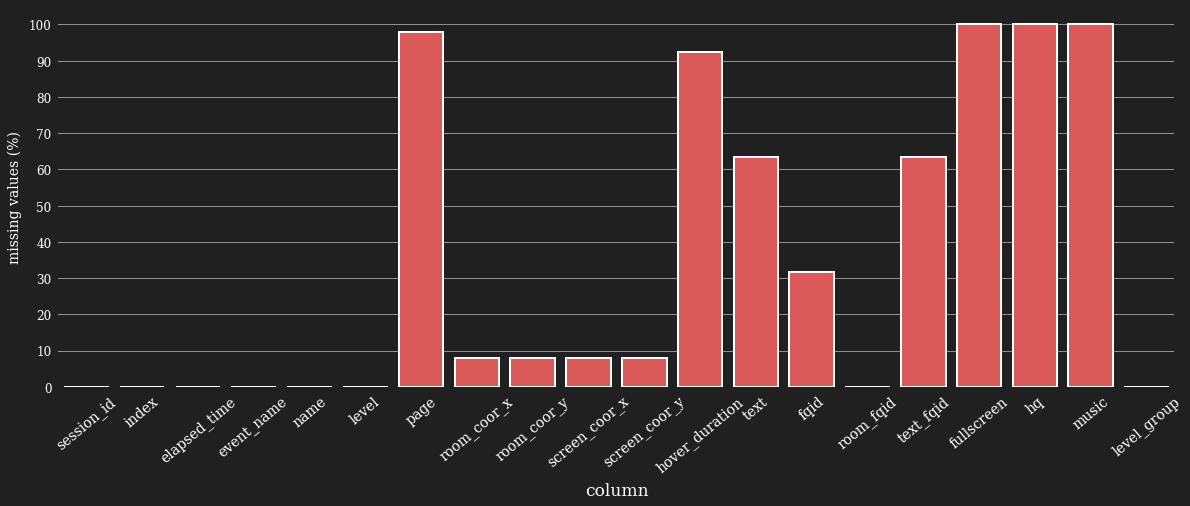

In [14]:
missing_values = get_missing_values(train, stat="percentage")

figure = plt.figure(figsize=(20, 7))
axis = figure.add_subplot()
axis.grid(axis="y", zorder=0)
sns.barplot(x="column", y="missing_values", data=missing_values, color=colors[0], edgecolor=TEXT_COLOR, label="Train dataset", alpha=1.0, linewidth=2.0, ax=axis, zorder=2)
axis.xaxis.set_tick_params(labelsize=14, rotation=40)
axis.set_xlabel("column", fontsize=17)
axis.yaxis.set_tick_params(labelsize=12)
axis.set_ylabel("missing values (%)", fontsize=14)
axis.set_yticks(range(0, 110, 10))
figure.show()

In [15]:
missed_columns = ["fullscreen", "hq", "music", "page", "hover_duration"]
train = train.drop(missed_columns, axis=1)
test = test.drop(missed_columns, axis=1)

In [16]:
unit = "MB"

memory_usage = get_memory_usage(train, unit=unit)
print(f"Memory usage of train dataset is {memory_usage} {unit}.")

train = reduce_memory_usage(train, return_copy=False)
optimized_memory_usage = get_memory_usage(train, unit=unit)
print(f"Memory usage of optimized train dataset is {optimized_memory_usage} {unit}.")

memory_usage_difference = (memory_usage - optimized_memory_usage)
memory_usage_percentage_difference = (memory_usage_difference / memory_usage) * 100
memory_usage_percentage_difference = round(memory_usage_percentage_difference, 2)
print(f"Memory usage of train dataset was decreased by {memory_usage_percentage_difference}%!")

print()

memory_usage = get_memory_usage(test, unit=unit)
print(f"Memory usage of test dataset is {memory_usage} {unit}.")

test = reduce_memory_usage(test, return_copy=False)
optimized_memory_usage = get_memory_usage(test, unit=unit)
print(f"Memory usage of optimized test dataset is {optimized_memory_usage} {unit}.")

memory_usage_difference = (memory_usage - optimized_memory_usage)
memory_usage_percentage_difference = (memory_usage_difference / memory_usage) * 100
memory_usage_percentage_difference = round(memory_usage_percentage_difference, 2)
print(f"Memory usage of test dataset was decreased by {memory_usage_percentage_difference}%!")

gc.collect()

Memory usage of train dataset is 1507.67 MB.
Memory usage of optimized train dataset is 402.08 MB.
Memory usage of train dataset was decreased by 73.33%!

Memory usage of test dataset is 0.46 MB.
Memory usage of optimized test dataset is 0.14 MB.
Memory usage of test dataset was decreased by 69.57%!


30

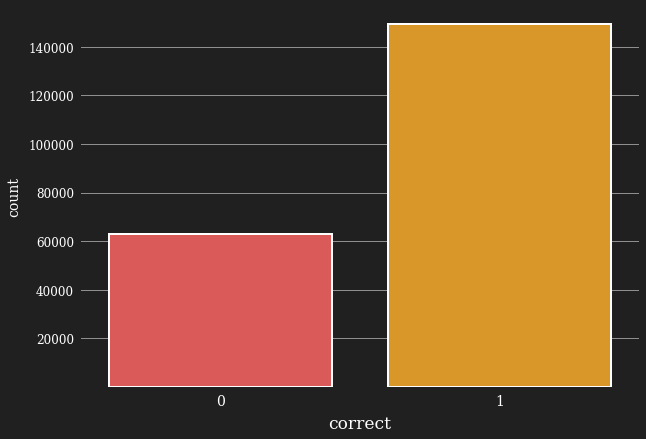

In [17]:
column = "correct"

figure = plt.figure(figsize=(10, 7))
axis = figure.add_subplot()
axis.grid(axis="y", zorder=0)
sns.countplot(x=column, data=train_labels, palette=colors,  edgecolor=TEXT_COLOR, linewidth=2.0, ax=axis, zorder=2)
axis.xaxis.set_tick_params(size=0, labelsize=14)
axis.set_xlabel(column, fontsize=17)
axis.yaxis.set_tick_params(size=0, labelsize=12)
axis.set_ylabel("count", fontsize=14)
axis.tick_params(axis="both", which="both", length=0)
axis.set_ylim(1)
figure.show()

In [18]:
grouped_session = train.groupby("session_id")
session_wise_statistics = pd.DataFrame({
    "num_events": grouped_session.size(),
    "elapsed_time": grouped_session["elapsed_time"].mean(),
})

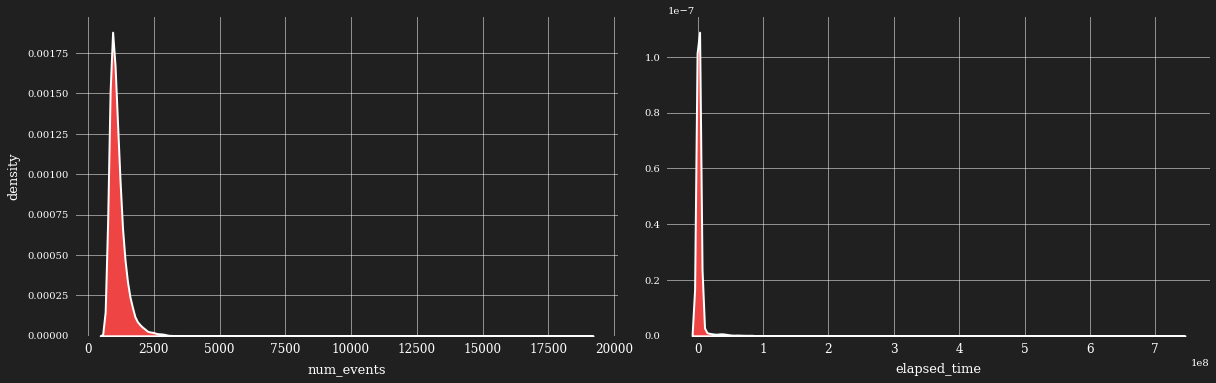

In [19]:
session_wise_columns = session_wise_statistics.columns
num_columns = len(session_wise_columns)

columns = 2
rows = (num_columns // columns)  + 1

figure = plt.figure(figsize=(17, 10))
for index, column in enumerate(session_wise_columns):
    data = session_wise_statistics[column].values
    
    axis = figure.add_subplot(rows, columns, index+1)
    axis.grid(axis="both", zorder=0)
    sns.kdeplot(x=data, fill=True, alpha=1.0, color=colors[0],  edgecolor=TEXT_COLOR,  linewidth=2, zorder=2, ax=axis)
    axis.xaxis.set_tick_params(labelsize=12)
    axis.set_xlabel(column, fontsize=13, labelpad=7)
    ylabel_text = "density"  if (index % columns) == 0 else ""
    axis.set_ylabel(ylabel_text, fontsize=13)
    axis.yaxis.set_tick_params(labelsize=10)

figure.tight_layout()
figure.show()

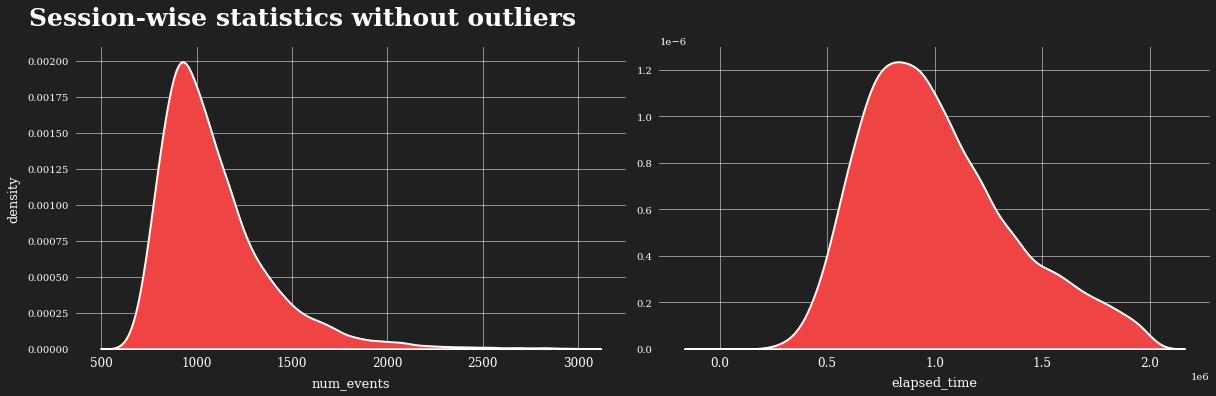

In [20]:
non_outliers_mask = (session_wise_statistics["num_events"] < 3000) & (session_wise_statistics["elapsed_time"] < 0.02*1e8)
non_outliers_session_wise_statistics = session_wise_statistics[non_outliers_mask]
session_wise_columns = non_outliers_session_wise_statistics.columns
num_columns = len(session_wise_columns)

columns = 2
rows = (num_columns // columns)  + 1

figure = plt.figure(figsize=(17, 10))
for index, column in enumerate(session_wise_columns):
    data = non_outliers_session_wise_statistics[column].values
    
    axis = figure.add_subplot(rows, columns, index+1)
    axis.grid(axis="both", zorder=0)
    sns.kdeplot(x=data, fill=True, alpha=1.0, color=colors[0],  edgecolor=TEXT_COLOR,  linewidth=2, zorder=2, ax=axis)
    axis.xaxis.set_tick_params(labelsize=12)
    axis.set_xlabel(column, fontsize=13, labelpad=7)
    ylabel_text = "density"  if (index % columns) == 0 else ""
    axis.set_ylabel(ylabel_text, fontsize=13)
    axis.yaxis.set_tick_params(labelsize=10)

figure.suptitle("Session-wise statistics without outliers", x=0.25, fontsize=25, fontweight="bold")
figure.tight_layout()
figure.show()

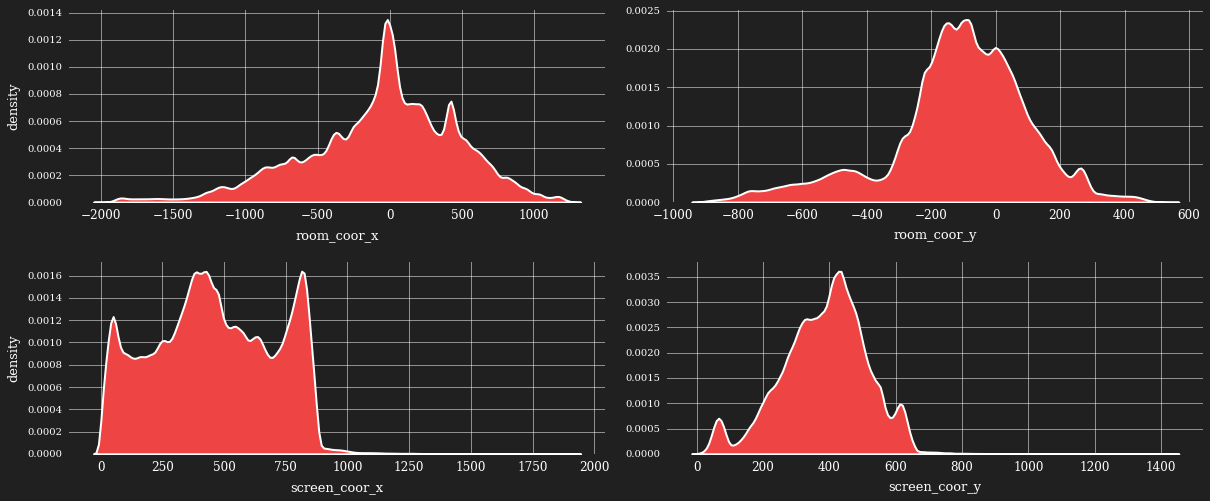

In [21]:
common_numerical_columns = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
num_common_numerical_columns_columns = len(common_numerical_columns)

columns = 2
rows = (num_common_numerical_columns_columns // columns)  + 1

figure = plt.figure(figsize=(17, 10))
for index, column in enumerate(common_numerical_columns):
    data = train[column].values
    
    axis = figure.add_subplot(rows, columns, index+1)
    axis.grid(axis="both", zorder=0)
    sns.kdeplot(x=data, fill=True, alpha=1.0, color=colors[0],  edgecolor=TEXT_COLOR,  linewidth=2.0, zorder=2, ax=axis)
    axis.xaxis.set_tick_params(labelsize=12)
    axis.set_xlabel(column, fontsize=13, labelpad=7)
    ylabel_text = "density"  if (index % columns) == 0 else ""
    axis.set_ylabel(ylabel_text, fontsize=13)
    axis.yaxis.set_tick_params(labelsize=10)

figure.tight_layout(w_pad=2, h_pad=2)
figure.show()

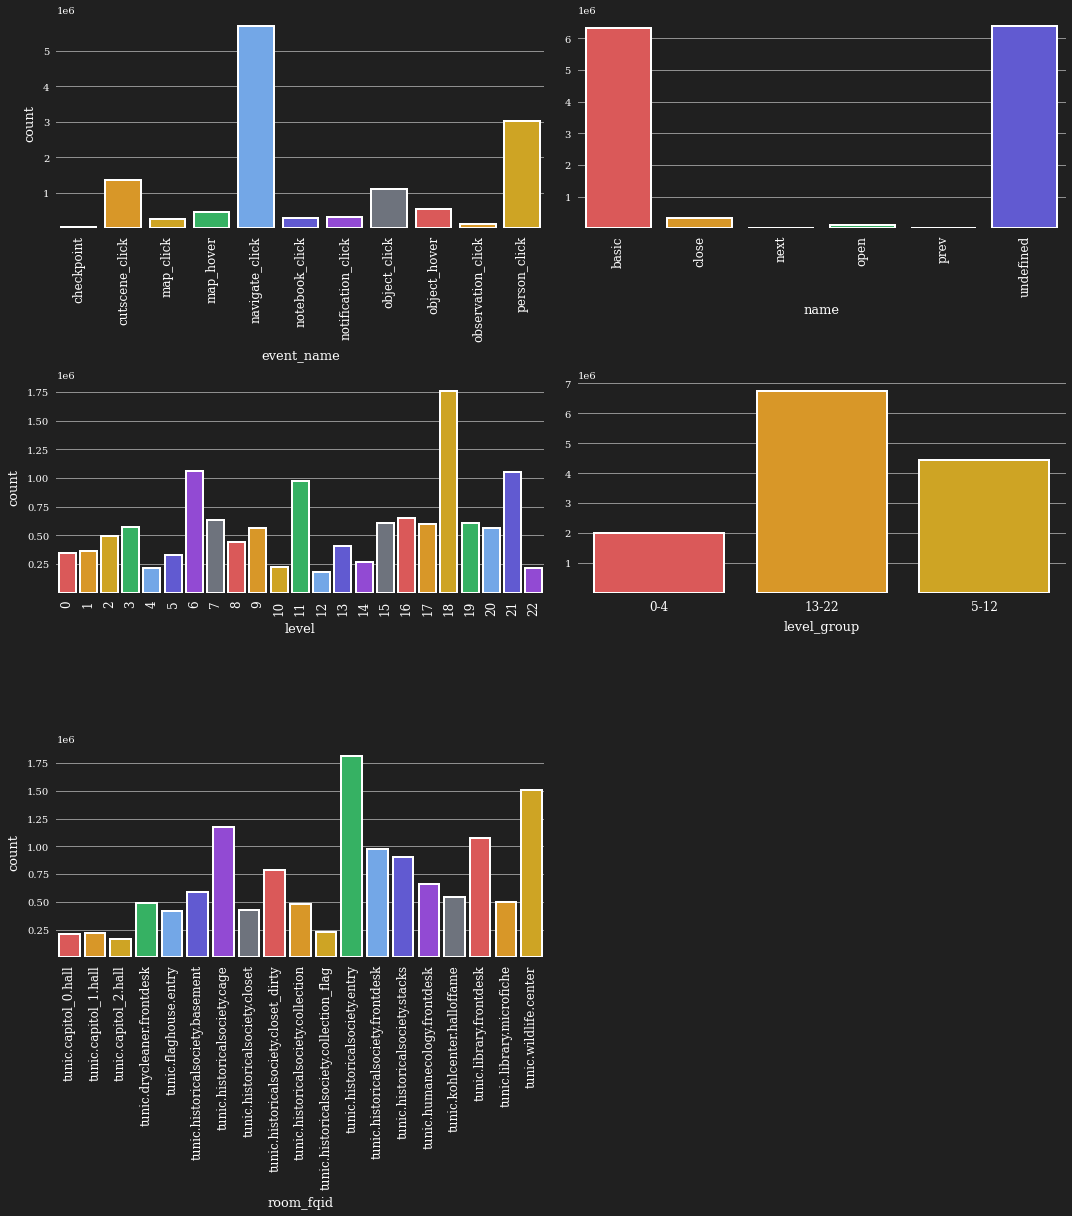

In [22]:
common_categorical_columns = ["event_name", "name", "level", "level_group", "room_fqid"]
num_common_categorical_columns = len(common_categorical_columns)

columns = 2
rows = (num_common_categorical_columns // columns)  + 1
rotate_ticks_threshold = 5

figure = plt.figure(figsize=(15, 17))
figure_colors = []
for index, column in enumerate(common_categorical_columns):
    data = train[column].values
    
    axis_colors = colors
    if index < len(figure_colors):
        axis_colors = figure_colors[index]
    
    axis = figure.add_subplot(rows, columns, index+1)
    axis.grid(axis="y", zorder=0)
    sns.countplot(x=data, fill=True, palette=axis_colors, alpha=1.0, edgecolor=TEXT_COLOR, linewidth=2.0, zorder=2, ax=axis)
    axis.xaxis.set_tick_params(labelsize=12)
    axis.set_xlabel(column, fontsize=13)
    ylabel_text = "count"  if (index % columns) == 0 else ""
    axis.set_ylabel(ylabel_text, fontsize=13)
    axis.yaxis.set_tick_params(labelsize=10)
    
    num_categories = len(set(data))
    if num_categories > rotate_ticks_threshold:
        axis.tick_params(axis="x", labelrotation=90)
    
    axis.set_ylim(1)
    
figure.tight_layout(h_pad=1, w_pad=2)
figure.show()

In [23]:
level_vs_elapsed_time = pd.DataFrame(train.groupby("level").agg({"elapsed_time": "mean"}))
level_vs_elapsed_time = level_vs_elapsed_time.reset_index(drop=False)
level_vs_elapsed_time.columns = ["level", "elapsed_time"]
level_vs_elapsed_time = level_vs_elapsed_time.sort_values(by="level", ascending=True)

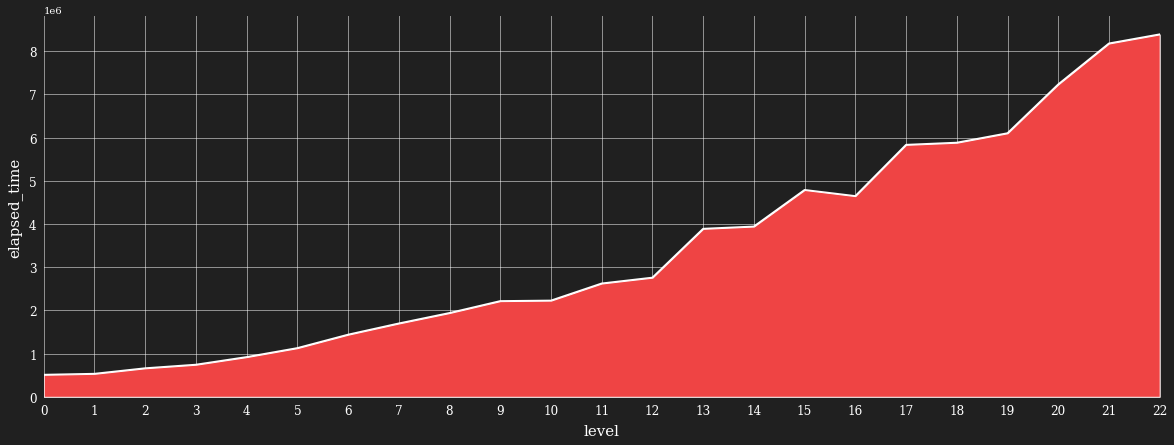

In [24]:
x, y = level_vs_elapsed_time["level"].values, level_vs_elapsed_time["elapsed_time"]
min_x, max_x = np.min(x), np.max(x)

figure = plt.figure(figsize=(20, 7))
axis = figure.add_subplot()
axis.grid(axis="both", zorder=0)
sns.lineplot(x=x, y=y, color=TEXT_COLOR, linewidth=2, alpha=1.0, ax=axis, zorder=2)
axis.yaxis.set_tick_params(labelsize=14)
axis.set_ylabel("elapsed_time", fontsize=15)
axis.set_xlabel("level", fontsize=15)
axis.xaxis.set_tick_params(labelsize=12)
axis.yaxis.set_tick_params(labelsize=12)
axis.fill_between(x, y, color=PRIMARY_COLOR, edgecolor=TEXT_COLOR, alpha=1.0, zorder=2)
axis.set_xticks(range(min_x, max_x+1, 1))
axis.set_xlim(min_x, max_x)
axis.set_ylim(0.0)
figure.show()

In [25]:
texts = train[~train["text"].isna()]["text"].values
num_words = np.array([len(str(text).split()) for text in texts])

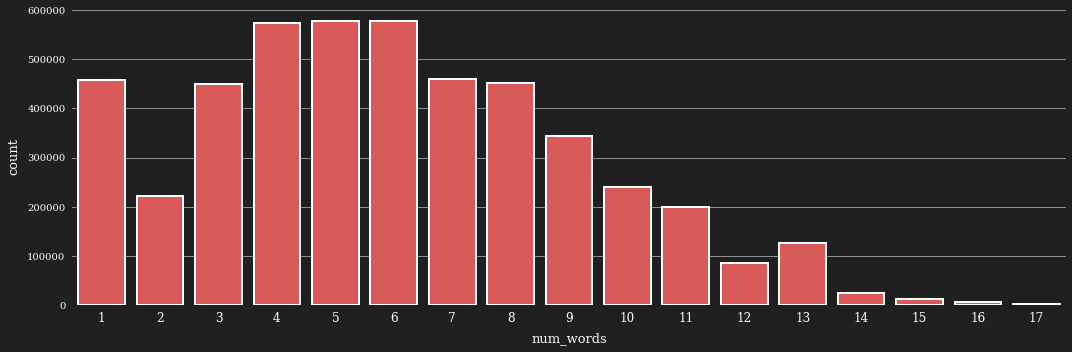

In [26]:
figure = plt.figure(figsize=(15, 5))
axis = figure.add_subplot()
axis.grid(axis="both", zorder=0)
sns.countplot(x=num_words, fill=True, alpha=1.0, color=colors[0],  edgecolor=TEXT_COLOR,  linewidth=2.0, zorder=2, ax=axis)
axis.xaxis.set_tick_params(labelsize=12)
axis.set_xlabel("num_words", fontsize=13, labelpad=7)
axis.set_ylabel("count", fontsize=13)
axis.yaxis.set_tick_params(labelsize=10)
axis.set_ylim(EPS)
    
figure.tight_layout()
figure.show()

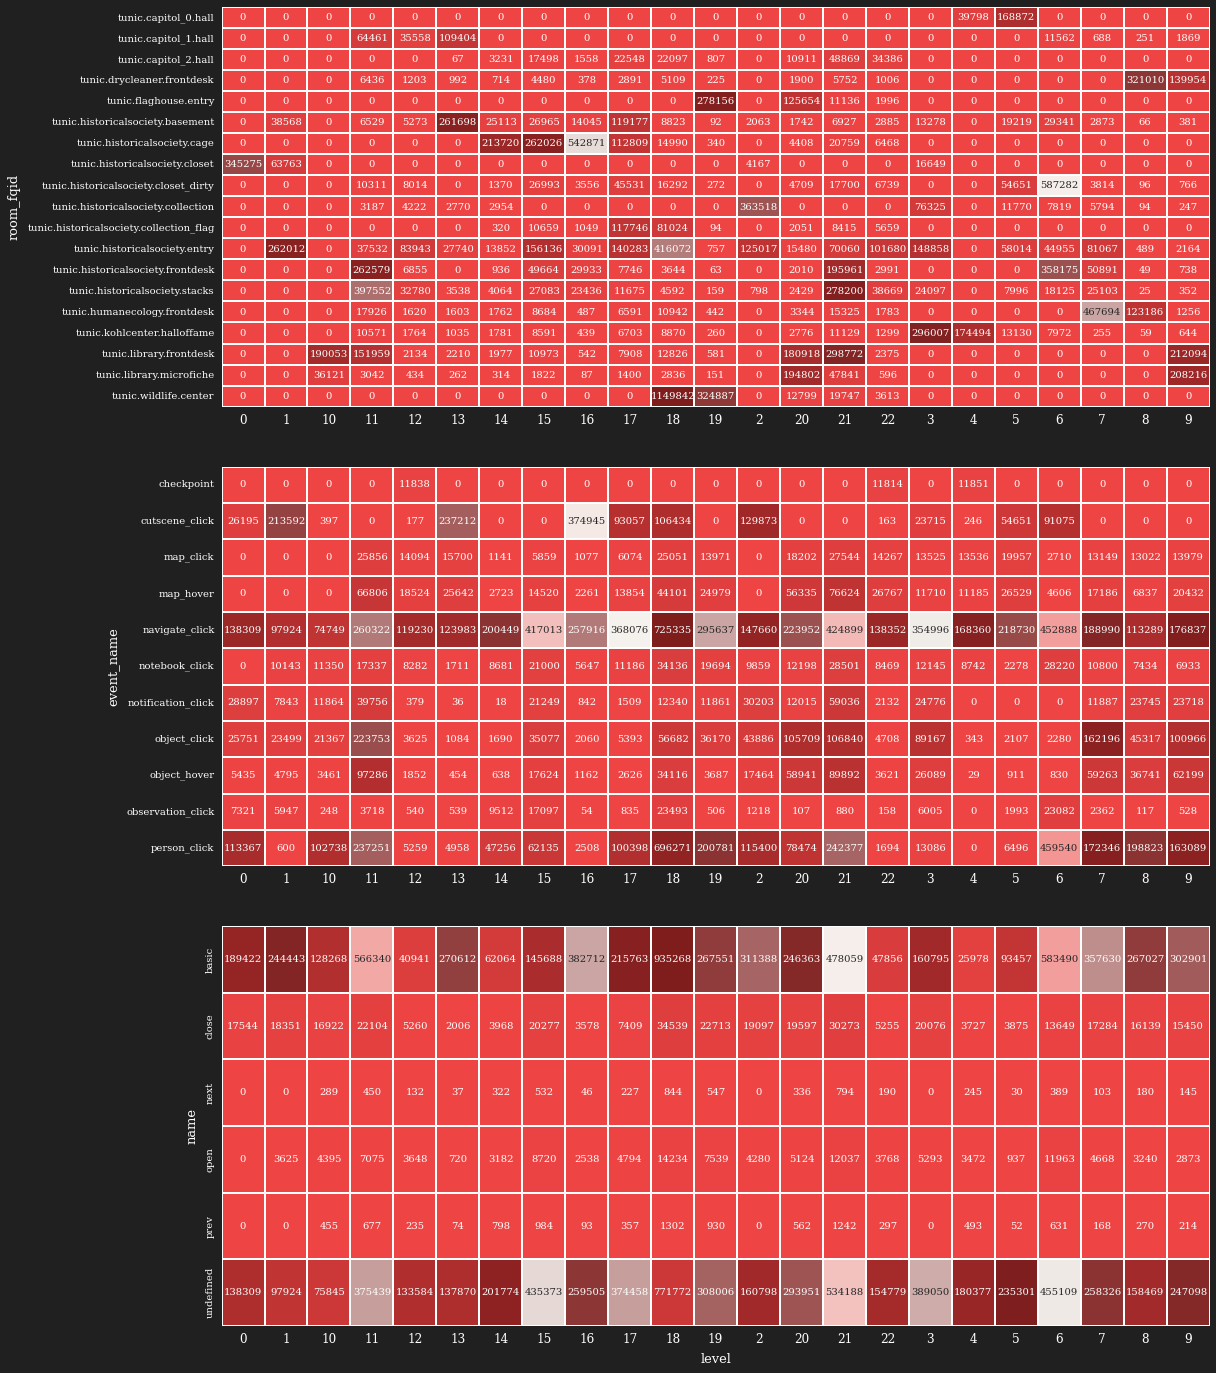

In [27]:
level_intersect_columns = ["room_fqid", "event_name", "name"]
num_level_intersect_columns = len(level_intersect_columns)

columns = 1
rows = (num_level_intersect_columns // columns) + 1
figure = plt.figure(figsize=(17, 25))
for index, column in enumerate(level_intersect_columns):
    axis = figure.add_subplot(rows, columns, index+1)
    categorical_vs_categorical_plot(x="level", y=column, data=train, annot=True, linecolor=TEXT_COLOR, linewidth=2.0, cbar=False, cmap=palette, ax=axis)
    axis.xaxis.set_tick_params(labelsize=12)
    xlabel_text = "level" if index >= (num_level_intersect_columns - columns) else "" 
    axis.set_xlabel(xlabel_text, fontsize=13)
    axis.yaxis.set_tick_params(labelsize=10)
    axis.set_ylabel(column, fontsize=13)
    
figure.tight_layout(w_pad=2, h_pad=2)
figure.show()

In [28]:
def visualize_session(session, plot_directory=None, plot_filename_format="{session_id}_{index}.png"):
    if plot_directory is None:
        plot_directory = str(session["session_id"].values[0])
        if not os.path.exists(plot_directory):
            os.mkdir(plot_directory)
    
    # screen
    screen_x_min, screen_y_min = session["screen_coor_x"].min(), session["screen_coor_y"].min()
    screen_x_max, screen_y_max = session["screen_coor_x"].max(), session["screen_coor_y"].max()
    screen_width, screen_height = screen_x_max - screen_x_min, screen_y_max - screen_y_min
    screen_padding = 25
    
    # room
    room_x_min, room_y_min = session["room_coor_x"].min(), session["room_coor_y"].min()
    room_x_max, room_y_max = session["room_coor_x"].max(), session["room_coor_y"].max()
    room_width, room_height = room_x_max - room_x_min, room_y_max - room_y_min
    
    plot_pathes = []
    for index, sample in session.iterrows():
        figure = plt.figure(figsize=(12, 10))
        axis = figure.add_subplot()
        
        # environment
        screen_rectangle = mpl.patches.Rectangle(xy=(screen_x_min, screen_y_min), width=screen_width, height=screen_height, edgecolor="#fff", label="Screen", color=colors[-1])
        axis.add_patch(screen_rectangle)
        
        room_rectangle = mpl.patches.Rectangle(xy=(room_x_min, room_y_min), width=room_width, height=room_height, edgecolor="#fff", label="Room", color=colors[2])
        axis.add_patch(room_rectangle)
        
        axis.set_xlim(screen_x_min - screen_padding, screen_x_max + screen_padding)
        axis.set_ylim(screen_y_min - screen_padding, screen_y_max + screen_padding)
        axis.set(xticks=[], yticks=[])
        axis.legend()
        
        # events
        room_x, room_y = sample["room_coor_x"], sample["room_coor_y"]
        screeen_x, screeen_y = sample["screen_coor_x"], sample["screen_coor_y"]
        axis.plot(room_x, room_y, color=colors[0], marker="o", markersize=5)
        axis.plot(screeen_x, screeen_y, color=colors[3], marker="o", markersize=5)
        axis.set_title("FQID: {fqid}, Level: {level}, Index: {index}, Event name: {event_name}".format(**sample.to_dict()), fontsize=20)
        
        # saving
        plot_filename = plot_filename_format.format(**sample.to_dict())
        plot_path = os.path.join(plot_directory, plot_filename)
        figure.savefig(plot_path)
        plt.close(figure) 
        
        plot_pathes.append(plot_path)
    
    plt_ims = [plt.imread(plot_path) for plot_path in plot_pathes]
    return run_animation(plt_ims)

In [30]:
def extract_date_from_session_id(data_frame, return_copy=False):
    """
    https://www.kaggle.com/code/pdnartreb/session-id-reverse-engineering
    """
    
    if return_copy:
        data_frame = copy.deepcopy(data_frame)
    
    data_frame["year"] = data_frame["session_id"].apply(lambda x: int(str(x)[:2]))
    data_frame["month"] = data_frame["session_id"].apply(lambda x: int(str(x)[2:4]) + 1)
    data_frame["weekday"] = data_frame["session_id"].apply(lambda x: int(str(x)[4:6]))
    data_frame["hour"] = data_frame["session_id"].apply(lambda x: int(str(x)[6:8]))
    data_frame["minute"] = data_frame["session_id"].apply(lambda x: int(str(x)[8:10]))
    data_frame["second"] = data_frame["session_id"].apply(lambda x: int(str(x)[10:12]))
    data_frame["ms"] = data_frame["session_id"].apply(lambda x: int(str(x)[12:15]))
    data_frame["?"] = data_frame["session_id"].apply(lambda x: int(str(x)[15:17]))
    
    return data_frame

In [31]:
train = extract_date_from_session_id(train)

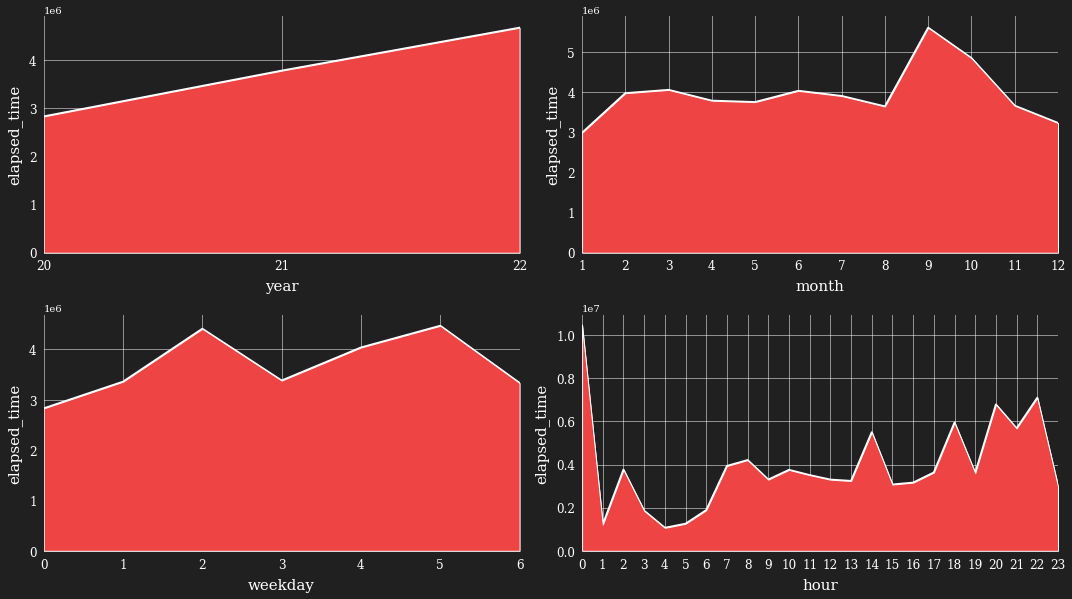

In [32]:
datetime_columns = ["year", "month", "weekday", "hour"]
num_datetime_columns = len(datetime_columns)

columns = 2
rows = int(num_datetime_columns // columns) + 1

figure = plt.figure(figsize=(15, 12))
for index, column in enumerate(datetime_columns):
    column_grouped = train.groupby(column).agg({"elapsed_time": "mean"})
    column_grouped = column_grouped.reset_index(drop=False)
    column_grouped.columns = [column, "elapsed_time"]
    
    x, y = column_grouped[column].values, column_grouped["elapsed_time"]
    min_x, max_x = np.min(x), np.max(x)

    axis = figure.add_subplot(rows, columns, index+1)
    axis.grid(axis="both", zorder=0)
    sns.lineplot(x=x, y=y, color=TEXT_COLOR, linewidth=2.0, alpha=1.0, ax=axis, zorder=2)
    axis.yaxis.set_tick_params(labelsize=14)
    axis.set_ylabel("elapsed_time", fontsize=15)
    axis.set_xlabel(column, fontsize=15)
    axis.xaxis.set_tick_params(labelsize=12)
    axis.yaxis.set_tick_params(labelsize=12)
    axis.fill_between(x, y, color=PRIMARY_COLOR, edgecolor=TEXT_COLOR, alpha=1.0, zorder=2)
    axis.set_xticks(range(min_x, max_x+1, 1))
    axis.set_xlim(min_x, max_x)
    axis.set_ylim(0.0)

figure.tight_layout()
figure.show()